SIMPLE LANE LINE IMPLEMENTATION 

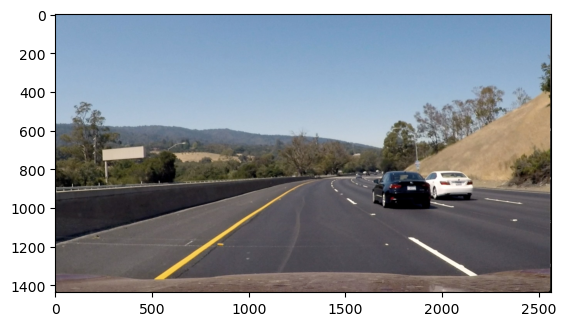

In [11]:
#import lIbraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

#read the image
image = mpimg.imread('/Users/sally/Desktop/Lane-Lines-Detection-master/Sample/SampleImage.jpeg')

plt.imshow(image)  

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math


def region_of_interest(img, vertices):
    
    mask = np.zeros_like(img)
    match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    line_img = np.zeros((img.shape[0], img.shape[1],3),dtype=np.uint8)
    img = np.copy(img)
    
    
    if lines is None:
        return
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
            
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    return img   


def pipeline(image):
    """
    An image processing pipeline which will output
    an image with the lane lines annotated.
    """
    height = image.shape[0]
    width = image.shape[1]
    
    region_of_interest_vertices = [(0, 950),(width / 2 - (width / 8), height / 2),(width, height),]
   

    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    cannyed_image = cv2.Canny(gray_image, 100, 200)
 
    cropped_image = region_of_interest(
        cannyed_image,
        np.array(
            [region_of_interest_vertices],
            np.int32
        ),
    )
 
    lines = cv2.HoughLinesP(
        cropped_image,
        rho=6,
        theta=np.pi / 60,
        threshold=160,
        lines=np.array([]),
        minLineLength=40,
        maxLineGap=25)
 
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
    
    if lines is not None:    
        for line in lines:
            for x1, y1, x2, y2 in line:
                slope = (y2 - y1) / (x2 - x1)
                if math.fabs(slope) < 0.5:
                    continue
                if slope <= 0:
                    left_line_x.extend([x1, x2])
                    left_line_y.extend([y1, y2])
                else:
                    right_line_x.extend([x1, x2])
                    right_line_y.extend([y1, y2])
            
            
        min_y = int(image.shape[0] * (3 / 5))
        max_y = int(image.shape[0])

        if len(left_line_y) > 0 and len(left_line_x) > 0:
            poly_left = np.poly1d(np.polyfit(
                left_line_y,
                left_line_x,
                deg=1
        ))

            left_x_start = int(poly_left(max_y))
            left_x_end = int(poly_left(min_y))

        else:
            return image


        if len(right_line_y) > 0 and len(right_line_x) > 0:
            poly_right = np.poly1d(np.polyfit(
                right_line_y,
                right_line_x,
               deg=1
        ))

            right_x_start = int(poly_right(max_y))
            right_x_end = int(poly_right(min_y))

        else:
            return image

        line_image = draw_lines(image,
            [[
                [left_x_start, max_y, left_x_end, min_y],
                [right_x_start, max_y, right_x_end, min_y],
            ]],
                thickness=5)

        return line_image
    else:
        return image
    
    
        

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML



output = 'SampleVideo.mp4'
clip1 = VideoFileClip("SampleVideo.mp4")
white_clip = clip1.fl_image(pipeline)
white_clip.write_videofile(output, audio=False)

Moviepy - Building video SampleVideo.mp4.
Moviepy - Writing video SampleVideo.mp4



Moviepy - Done !
Moviepy - video ready SampleVideo.mp4


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [38]:
"""import math

# Function to convert an image to grayscale
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Function to apply Canny edge detection
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

# Function to apply Gaussian blur
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# Function to apply a region of interest mask
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Function to draw lane lines on the image
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    imshape = img.shape
    left_lines = []
    right_lines = []
    left_lines_aligned = []
    right_lines_aligned = []
    left_m = []
    left_b = []
    right_m = []
    right_b = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            m = (y2 - y1) / (x2 - x1)
            b = y1 - (m * x1)
            if m < 0:
                left_lines.append((m, b))
            if m > 0:
                right_lines.append((m, b))
    left_m = [line[0] for line in left_lines]
    left_m_avg = np.mean(left_m)
    left_m_std = np.std(left_m)
    for line in left_lines:
        if abs(line[0] - left_m_avg) < left_m_std:
            left_lines_aligned.append(line)
    if len(left_lines_aligned) > 0:
        left_m = [line[0] for line in left_lines_aligned]
        ml = np.mean(left_m)
        left_b = [line[1] for line in left_lines_aligned]
        bl = np.mean(left_b)
    else:
        ml = left_m_avg
        left_b = [line[1] for line in left_lines]
        bl = np.mean(left_b)
    right_m = [line[0] for line in right_lines]
    right_m_avg = np.mean(right_m)
    right_m_std = np.std(right_m)
    for line in right_lines:
        if abs(line[0] - right_m_avg) < right_m_std:
            right_lines_aligned.append(line)
    if len(right_lines_aligned) > 0:
        right_m = [line[0] for line in right_lines_aligned]
        mr = np.mean(right_m)
        right_b = [line[1] for line in right_lines_aligned]
        br = np.mean(right_b)
    else:
        mr = right_m_avg
        right_b = [line[1] for line in right_lines]
        br = np.mean(right_b)
    smooth_fact = 0.8
    if (abs(ml) < 1000):
        if (previous_lines[0] != 0):
            ml = previous_lines[0] * smooth_fact + ml * (1 - smooth_fact)
            bl = previous_lines[1] * smooth_fact + bl * (1 - smooth_fact)
    elif (previous_lines[0] != 0):
        ml = previous_lines[0]
        bl = previous_lines[1]
    if (abs(mr) < 1000):
        if (previous_lines[2] != 0):
            mr = previous_lines[2] * smooth_fact + mr * (1 - smooth_fact)
            br = previous_lines[3] * smooth_fact + br * (1 - smooth_fact)
    elif (previous_lines[2] != 0):
        mr = previous_lines[2]
        br = previous_lines[3]
    x1l = int((bl - imshape[0]) / (-1 * ml))
    y1l = imshape[0]
    x2l = int((bl - 6 * imshape[0] / 10) / (-1 * ml))
    #y2l = int(6 * imshape[0] / 10)
    y2l = int(imshape[0] * (3/5))  # Higher point (adjust to make lines extend farther)
    x1r = int((br - 6 * imshape[0] / 10) / (-1 * mr))
    y2r = int(imshape[0])  # Bottom of the image
    x2r = int((br - imshape[0]) / (-1 * mr))
    y1r = int(imshape[0] * (3/5)) 
    if (x2l < x1r):
        cv2.line(img, (x1l, y1l), (x2l, y2l), [0, 255, 0], thickness)
        cv2.line(img, (x1r, y1r), (x2r, y2r), [0, 0, 255], thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Function to overlay lines on the original image
def weighted_img(img, initial_img, α=0.8, β=0.6, γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)


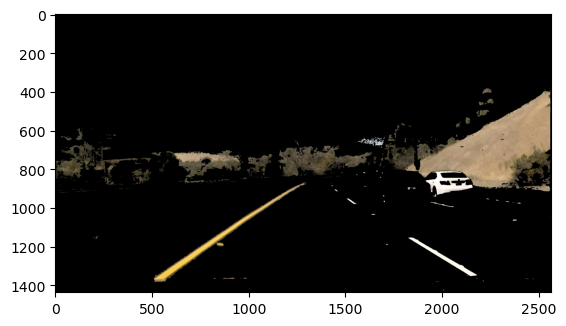

In [39]:
""""img = mpimg.imread('/Users/sally/Desktop/TestSample/SampleImage.jpeg')

### color selection###
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

mask_white = cv2.inRange(img, (200,200,200), (255, 255, 255))
mask_yellow = cv2.inRange(hsv_img, (15,60,20), (25, 255, 255))
color_mask = cv2.bitwise_or(mask_white, mask_yellow)
masked_img = np.copy(img)
masked_img[color_mask == 0] = [0,0,0]

plt.imshow(masked_img)

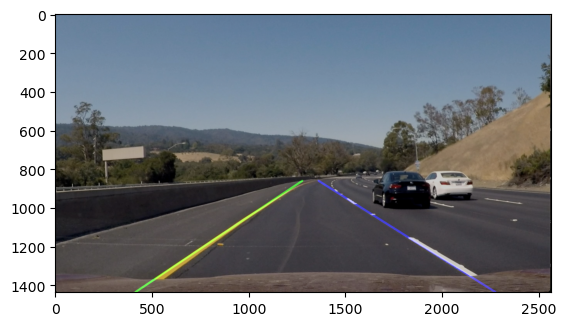

In [40]:
""""#building pipeline on sample image
previous_lines = [0, 0, 0, 0]
def lane_finding_pipeline(img): 
    
    ### create a color mask ###
    #convert from RGB to HSV
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    #define two color masks for yellow and white
    mask_white = cv2.inRange(img, (200,200,200), (255, 255, 255))
    mask_yellow = cv2.inRange(hsv_img, (15,60,20), (25, 255, 255))
    
    
    #combine the two masks, both yellow and white pixels are of interest
    color_mask = cv2.bitwise_or(mask_white, mask_yellow)
    
    
    #make a copy of the original image
    masked_img = np.copy(img)
    
    #pixels that are not part of the mask(neither white or yellow) are made black
    masked_img[color_mask == 0] = [0,0,0]
    
    ### smoothen image ###
    #turn the masked image to grayscale for easier processing
    gray_img = grayscale(masked_img)
    
    
    #to get rid of imperfections, apply the gaussian blur
    kernel_size = 5
    blurred_gray_img = gaussian_blur(gray_img, kernel_size)

    ### detect edges ###
    low_threshold = 100
    high_threshold = 200
    edges_from_img = canny(blurred_gray_img, low_threshold, high_threshold)

    
    imshape = img.shape
    vertices = np.array([[(0,imshape[0]),(4*imshape[1]/9, 6*imshape[0]/10), (5*imshape[1]/9, 6*imshape[0]/10), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges_from_img, vertices)

    ### find lines from edges pixels ###
    #define parameters for the Hough transform
    #Hough grid resolution in pixels
    rho = 6
    
    #Hough grid angular resolution in radians 
    theta = np.pi/60 
    
    #minimum number of sines intersecting in a cell, collinear points to form a line
    threshold = 160
    
    #minimum length of a line in pixels
    min_line_len = 40
    
    
    #maximum gap in pixels between segments to be considered part of the same line 
    max_line_gap = 25  
    
    #apply Hough transform to color masked grayscale blurred image
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    ### overlay image and lines ###
    overlay_img = weighted_img(line_img, img)
    return overlay_img



img = mpimg.imread('/Users/sally/Desktop/TestSample/SampleImage.jpeg')
img_out = lane_finding_pipeline(img)
plt.imshow(img_out)
previous_lines = [0, 0, 0, 0]

In [33]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    result = lane_finding_pipeline(image)
    return result


output = '/Users/sally/Desktop/TestSample/SampleVideo.mp4'
clip2 = VideoFileClip('/Users/sally/Desktop/TestSample/SampleVideo.mp4')
output_clip = clip2.fl_image(process_image)
%time output_clip.write_videofile(output, audio=False)
previous_lines = [0, 0, 0, 0]


Moviepy - Building video /Users/sally/Desktop/TestSample/SampleVideo.mp4.
Moviepy - Writing video /Users/sally/Desktop/TestSample/SampleVideo.mp4



Moviepy - Done !
Moviepy - video ready /Users/sally/Desktop/TestSample/SampleVideo.mp4
CPU times: user 48.8 ms, sys: 36.1 ms, total: 84.9 ms
Wall time: 116 ms


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:
/Users/sally/Desktop/TestSample/SampleVideo.mp4